In [ ]:
#Setting up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# sklearn utility functions for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

class XGBoostClassifier:

    def __init__(self, X, y, feature_names):

        self.feature_names = feature_names

        # split into test and training datasets
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(X, y, \
                             test_size=0.2, \
                             random_state=np.random.randint(0, 100), \
                             shuffle=True)

        # standardize features
        self.X_train = StandardScaler().fit_transform(self.X_train)
        self.X_test = StandardScaler().fit_transform(self.X_test)
        
        # turn into xgboost dmatrices
        self.train_dm = xgb.DMatrix(pd.DataFrame(data=self.X_train, \
                                                 columns=feature_names), \
                                                 label=self.y_train)
        self.test_dm = xgb.DMatrix(pd.DataFrame(data=self.X_test, \
                                                columns=feature_names), \
                                                label=self.y_test)

    # train the model, and show evaluation statistics on the test dataset
    def train_eval(self, num_rounds, max_depth):
        eval_list = [(self.train_dm, 'train'), (self.test_dm, 'eval')]
        xgb_classifier = xgb.XGBRegressor()
        
        parms = {
            'nthread':        [4],
            'objective':      ['reg:squarederror'], # textbook uses Huber loss;
                                                    # colab doesn't have newest xgboost
                                                    # so we just use reg:squarederror
            'learning_rate':  [0.05],
            'max_depth':      [max_depth],
            'n_estimators':   [num_rounds],
            'eval_metric':    ['mae'],              # mean absolute error
        }
        # grid search to find the optimal parameters
        xgb_grid = GridSearchCV(xgb_classifier,
                                parms,
                                cv=2,
                                n_jobs=5,
                                verbose=True)

        xgb_grid.fit(self.X_train, self.y_train)
        print(f'Best score from grid search: {xgb_grid.best_score_}')
        print(f'Best parameters from grid search: {xgb_grid.best_score_}')
        self.progress = {}        
        self.xgb_classifier = xgb.train(xgb_grid.best_params_,
                                        self.train_dm,
                                        num_boost_round=100,
                                        evals=eval_list,
                                        evals_result=self.progress,
                                        early_stopping_rounds=100,
                                        verbose_eval=False)

    # plot average absolute error vs. iterations; assumes model has 
    # already been trained
    def gb_mae(self):
      return (self.progress['eval']['mae'])

    def random_forest(self,n_trees, m ):
      self.trees = list(range(1, n_trees))
      self._mae = np.zeros(len(self.trees))
      for i in range(n_trees -1):
        tree = self.trees[i]
        regressor = RandomForestRegressor(n_estimators=tree, max_features=m)
        regressor.fit(self.X_train, self.y_train)
        y_pred = regressor.predict(self.X_test)
        self._mae[i] = metrics.mean_absolute_error(self.y_test, y_pred)
        print(i)
    def rf_mae(self):
      return self._mae
    def num_trees(self):
      return self.trees



      # california housing dataset from sklearn
from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

n_trees = 275

# create classifier
classifier = XGBoostClassifier(X, y, cal_housing.feature_names)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    3.4s finished


Best score from grid search: 0.8049024718829725
Best parameters from grid search: 0.8049024718829725


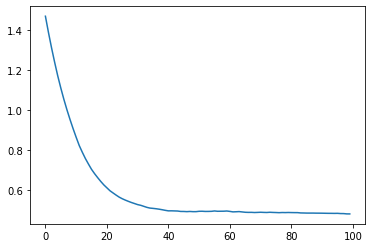

In [ ]:
# train classifier
classifier.train_eval(n_trees, 4)
GBM_depth_4 = classifier.gb_mae()

plt.figure()
plt.plot(GBM_depth_4)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:    5.4s finished


Best score from grid search: 0.8192566595418167
Best parameters from grid search: 0.8192566595418167


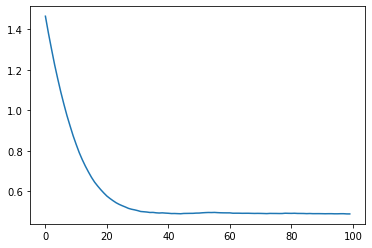

In [ ]:
classifier.train_eval(n_trees, 6)
GBM_depth_6 = classifier.gb_mae()

plt.figure()
plt.plot(GBM_depth_6)

In [ ]:
classifier.random_forest(n_trees,2)
RF_m_2 = classifier.rf_mae()

In [ ]:
classifier.random_forest(n_trees,6)
RF_m_6 = classifier.rf_mae()

In [ ]:
plt.figure()
plt.plot(GBM_depth_4)
plt.plot(GBM_depth_6)
plt.plot(RF_m_2)
plt.plot(RF_m_6)
plt.legend(['GBM depth=4', 'GBM depth=6', 'RF m=2', 'RF m=6'])
plt.title('California Housing Data')
plt.ylim([0, 1])
plt.xlim([0, n_trees])
plt.xlabel('Number of Trees')
plt.show()